In [2]:
!pip install pmlb
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
from pmlb import fetch_data
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import regularizers
from sklearn.ensemble import BaggingRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
#import tensorflow_addons as tfa

# Homework 2 - part II

**First: go to Runtime > Change runtime type > select GPU or TPU to accelerate the computations**

This part of the homework of more about "the art of machine learning", where you will have to play with hyperparameters to get a good result.

For this part of the homework you can work with a classmate. If so, write it here:

"I worked with ________________"

Here, we will work with some real data, where we will try to predict the time that it takes for a car to get from 0 to 60 miles per hour (96 km/h) in seconds, based on the following attributes:
- miles per gallon: how many miles can you drive the car with one gallon of gasoline.
- cylinders of the engine
- size of the engine
- horsepower
- weight
- year of fabrication. The cars are old, between 1971 and 1983.

You can browse the dataset [here](https://epistasislab.github.io/penn-ml-benchmarks/profile/cars.html)

In [4]:
data = fetch_data("cars")
data.describe()

,MPG,cylinders,cubicInches,horsepower,weightLbs,time-to-sixty,year,brand,target
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.413265,104.469388,2977.584184,15.681122,1976.979592,13.323980,1.451531
std,7.805007,1.705783,104.642823,38.491160,849.402560,2.761232,3.683737,8.558786,0.772082
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,1971.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,14.000000,1974.000000,6.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,16.000000,1977.000000,11.000000,2.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.000000,1980.000000,21.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,25.000000,1983.000000,29.000000,2.000000


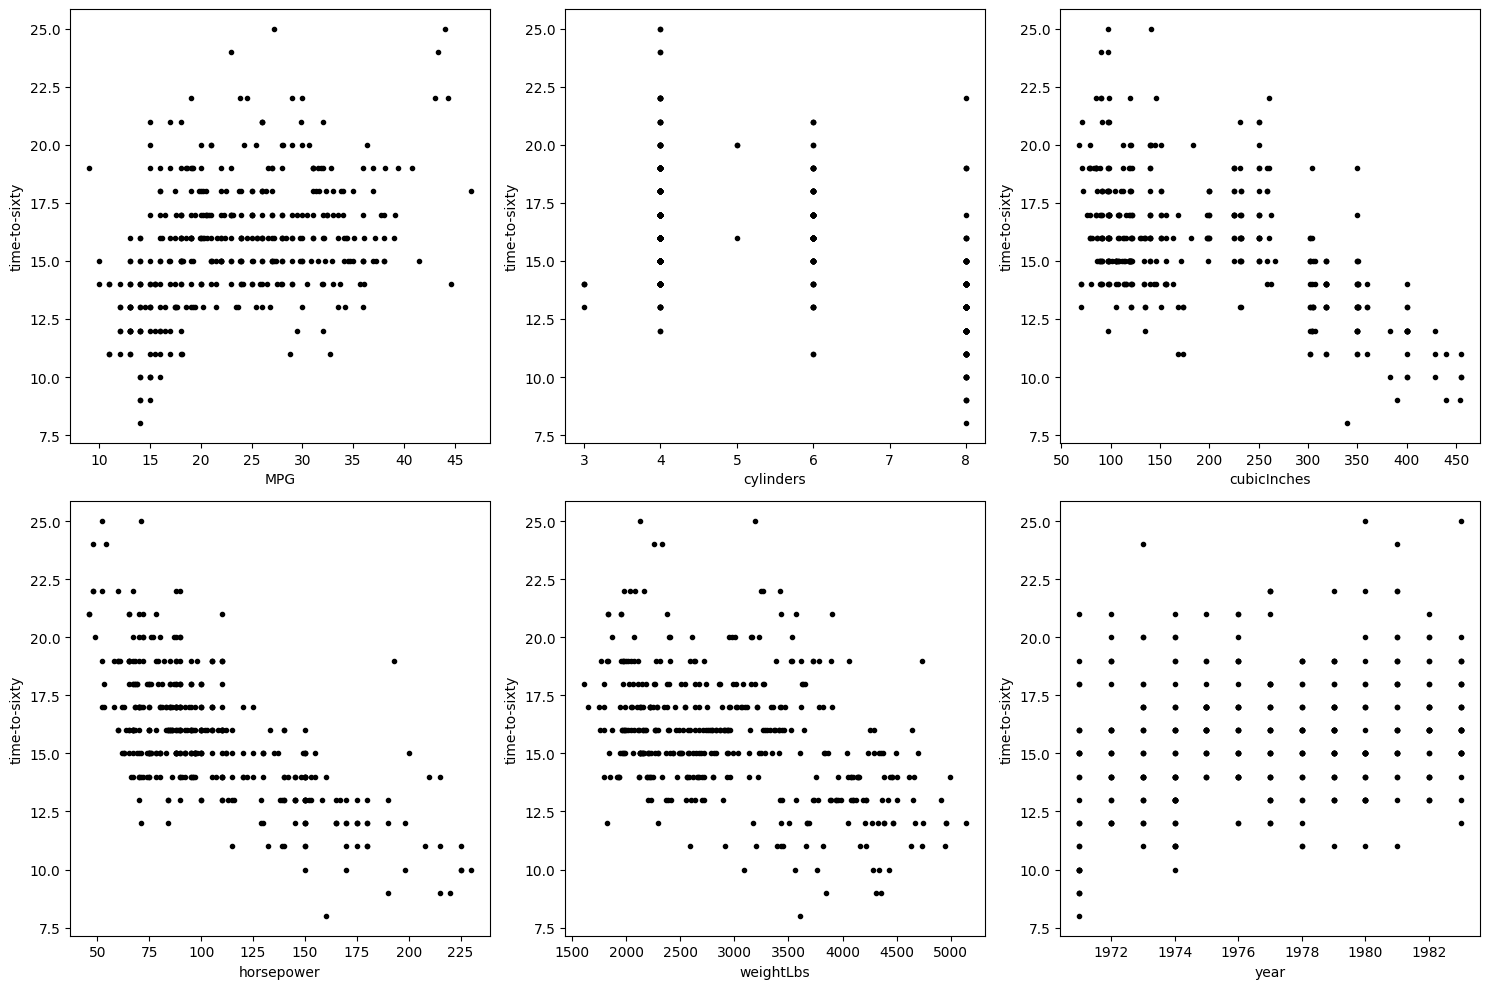

In [5]:
fields = ['MPG', 'cylinders', 'cubicInches', 'horsepower', 'weightLbs', 'year']

fig = plt.figure()
fig.set_size_inches((15,10))
for i, field in enumerate(fields):
  plt.subplot(2, 3, i + 1)
  plt.plot(data[field], data['time-to-sixty'], 'k.')
  plt.xlabel(field)
  plt.ylabel('time-to-sixty')

plt.tight_layout()

In [6]:
Y = data['time-to-sixty'].to_numpy()[:,None]
X = data[['MPG', 'cylinders', 'cubicInches', 'horsepower', 'weightLbs', 'year']]

A key step to train a neural network (and many other machine learning algorithms) is to normalize the data in a way that both the input and the output will have zero mean and variance equal to one:

In [7]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu


X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

Now, we will split the data into train, validation and test sets. Note that we can use the validation set to make decisions about the parameters, but the performance will be evaluated with the test set.

In [8]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0], 'validation samples', X_val.shape[0], 'test samples:', X_test.shape[0])

training samples: 235 validation samples 59 test samples: 98


## Problem 1 [25 points]

Tune the hyperparameters until you meet the two following conditions:
1. The mean squared error on the test set is less than 0.23.
2. The mean squared error in the training set is lower than in the test set. Otherwise, your neural network would be overfitting the test set, which is worse than overfitting the training set, because it is smaller.

Some considerations:
- You can change all the hyperparameters, width, depth, optimizer, activation function, learning rate.
- Feel free to add regularization strategies. [See here](https://colab.research.google.com/drive/1I6l1kU8YhCuAR8fLYBZI5QVK8-o6hLnl?usp=sharing) for the notebook with regularization examples.
- The only strategy that is not allowed is to use early stopping with the test set. We have the validation set for that. Also, manually tunning the number of epochs to do early stopping on the test set is not allowed. This will be easy to notice.
- Feel free to automate the parameter search process.

## Problem 2 [5 points]
Comment why is not possible to achieve zero error both in the traning and test sets and relate it to a concept we learned in "Introduction to machine learning" chapter.

 width,
 depth,
  optimizer,
  activation function,
   learning rate

In [10]:
width = 30 ## change
depth = 3 ## change

net_input = Input(shape=(Xn.shape[1],),name='input')

net_output = Sequential([Dense(width, 'relu', input_shape = (Xn.shape[1],))]
                        + [Dense(width, 'relu')]*(depth - 2)+
                         [Dense(1, 'linear')], name = 'base_NN')(net_input)

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

history = model.fit(X_train, y_train, epochs=1500, batch_size = 32, validation_data= (X_val, y_val),callbacks = TqdmCallback(), verbose = 0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [1]:
plt.plot(history.history['mean_squared_error'], label = 'training loss')
plt.plot(history.history['val_mean_squared_error'], label = 'validation loss')
plt.yscale('log')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs/100')

y_star_train = model.predict(X_train)
y_star_test = model.predict(X_test)
plt.figure()
plt.plot(y_train, y_star_train, 'r.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')
plt.figure()
plt.plot(y_test, y_star_test, 'b.')
plt.plot([y_star_test.min(), y_star_test.max()], [y_star_test.min(), y_star_test.max()], 'k')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')

MSE_test = np.average((y_star_test - y_test)**2)
MSE_train = np.average((y_star_train - y_train)**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)
print("MSE train < MSE test?", MSE_train < MSE_test)
print("MSE test < 0.23?", MSE_test < 0.23)

NameError: name 'plt' is not defined